# 1 Common data problems

Overcoming some of the most common dirty data problems. Converting data types, apply range constraints to remove future data points, and remove duplicated data points to avoid double-counting.

## Data types constraints

### Numeric data or ... ?

Exploring bicycle ride sharing data in San Francisco called `ride_sharing`. It contains information on the start and end stations, the trip duration, and some user information for a bike sharing service.

The `user_type` column contains information on whether a user is taking a free ride and takes on the following values:

* `1` for free riders.
* `2` for pay per ride.
* `3` for monthly subscribers.

In [35]:
import pandas as pd
import datetime as dt
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from fuzzywuzzy import process
%matplotlib inline

In [2]:
ride_sharing = pd.read_csv("../data/ride_sharing.csv")
ride_sharing.head()

,ride_id,duration,station_A_id,station_A_name,station_B_id,station_B_name,bike_id,user_type,user_birth_year,user_gender,tire_sizes,ride_date
0,0,11,16,Steuart St at Market St,93,4th St at Mission Bay Blvd S,5504,Subscriber,1988,Male,27,2018-03-04
1,1,8,3,Powell St BART Station (Market St at 4th St),93,4th St at Mission Bay Blvd S,2915,Subscriber,1988,Male,27,2017-03-27
2,2,11,15,San Francisco Ferry Building (Harry Bridges Pl...,67,San Francisco Caltrain Station 2 (Townsend St...,5340,Customer,1988,Male,26,2019-06-30
3,3,7,21,Montgomery St BART Station (Market St at 2nd St),50,2nd St at Townsend St,746,Subscriber,1969,Male,27,2018-11-16
4,4,11,81,Berry St at 4th St,21,Montgomery St BART Station (Market St at 2nd St),5477,Subscriber,1986,Male,26,2017-11-01


In [3]:
ride_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          78 non-null     int64 
 1   duration         78 non-null     int64 
 2   station_A_id     78 non-null     int64 
 3   station_A_name   78 non-null     object
 4   station_B_id     78 non-null     int64 
 5   station_B_name   78 non-null     object
 6   bike_id          78 non-null     int64 
 7   user_type        78 non-null     object
 8   user_birth_year  78 non-null     int64 
 9   user_gender      78 non-null     object
 10  tire_sizes       78 non-null     int64 
 11  ride_date        78 non-null     object
dtypes: int64(7), object(5)
memory usage: 7.4+ KB


In [4]:
ride_sharing.user_type.describe()

count             78
unique             2
top       Subscriber
freq              71
Name: user_type, dtype: object

By looking at the summary statistics - they don't really seem to offer much description on how users are distributed along their purchase type, The `user_type` column has an finite set of possible values that represent groupings of data, it should be converted to `category`.

In [5]:
ride_sharing["user_type_cat"] = ride_sharing.user_type.astype("category")
assert ride_sharing.user_type_cat.dtype == "category"

In [6]:
ride_sharing.user_type_cat.describe()

count             78
unique             2
top       Subscriber
freq              71
Name: user_type_cat, dtype: object

it seems that most users are pay per ride users!

### Summing strings and concatenating numbers

Converting the string column `duration` to the type `int`.

In [7]:
ride_sharing.dtypes

ride_id               int64
duration              int64
station_A_id          int64
station_A_name       object
station_B_id          int64
station_B_name       object
bike_id               int64
user_type            object
user_birth_year       int64
user_gender          object
tire_sizes            int64
ride_date            object
user_type_cat      category
dtype: object

## Data Range Constraints

### Tire size contraints

Working with the tire_sizes column which contains data on each bike's tire size. Bicycle tire sizes could be either `26″`, `27″` or `29″` and are here correctly stored as a categorical value. In an effort to cut maintenance costs, the ride sharing provider decided to set the maximum tire size to be `27″`. Let's make sure the `tire_sizes` column has the correct range by first converting it to an integer, then setting and testing the new upper limit of `27″` for tire sizes.

In [8]:
# Convert tire_sizes to integer
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('int')

# Set all values above 27 to 27
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27

# Reconvert tire_sizes back to categorical
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')

# Print tire size description
ride_sharing['tire_sizes'].describe()

count     78
unique     2
top       27
freq      45
Name: tire_sizes, dtype: int64

### Back to the future

A bug was discovered which was relaying rides taken today as taken next year. To fix this, we will find all instances of the `ride_date` column that occur anytime in the future, and set the maximum possible value of this column to today's date. Before doing so, we need to convert `ride_date` to a datetime object.

In [9]:
# Convert ride_date to datetime
ride_sharing['ride_date'] = pd.to_datetime(ride_sharing['ride_date'])

# Save today's date
today = pd.to_datetime('today')

# Set all in the future to today's date
ride_sharing.loc[ride_sharing['ride_date'] > today, 'ride_date'] = today

# Print maximum of ride_date column
ride_sharing['ride_date'].max()

Timestamp('2020-01-17 00:00:00')

## Uniqueness Constraints

### Finding duplicates

The number of rides taken has increased by `20%` overnight, leading us to think there might be both complete and incomplete duplicates in the `ride_sharing` DataFrame. Let's confirm this suspicion by finding those duplicates. 

In [10]:
# Find duplicates
duplicates = ride_sharing.duplicated('ride_id', keep=False)

# Sort your duplicated rides
duplicated_rides = ride_sharing[duplicates].sort_values('ride_id')

# Print relevant columns of duplicated_rides
print(duplicated_rides[['ride_id','duration','user_birth_year']])

    ride_id  duration  user_birth_year
22       33        10             1979
39       33         2             1979
53       55         9             1985
65       55         9             1985
74       71        11             1997
75       71        11             1997
76       89         9             1986
77       89         9             2060


Notice that rides 33 and 89 are incomplete duplicates, whereas the remaining are complete.

### Treating duplicates

Let's treat those duplicated rows by first dropping complete duplicates, and then merging the incomplete duplicate rows into one while keeping the average `duration`, and the minimum `user_birth_year` for each set of incomplete duplicate rows.

In [11]:
# Drop complete duplicates from ride_sharing
ride_dup = ride_sharing.drop_duplicates()

# Create statistics dictionary for aggregation function
statistics = {'user_birth_year': 'min', 'duration': 'mean'}

# Group by ride_id and compute new statistics
ride_unique = ride_dup.groupby('ride_id').agg(statistics).reset_index()

# Find duplicated values again
duplicates = ride_unique.duplicated(subset = 'ride_id', keep = False)
duplicated_rides = ride_unique[duplicates == True]

# Assert duplicates are processed
assert duplicated_rides.shape[0] == 0

# 2 Text and categorical data problems

Categorical and text data can often be some of the messiest parts of a dataset due to their unstructured nature. In this section, we wil fix whitespace and capitalization inconsistencies in category labels, collapse multiple categories into one, and reformat strings for consistency.

## Membership constraints

We will be working with the `airlines` DataFrame which contains survey responses on the San Francisco Airport from airline customers. The DataFrame contains flight metadata such as the airline, the destination, waiting times as well as answers to key questions regarding cleanliness, safety, and satisfaction. Another DataFrame named `categories` was created, containing all correct possible values for the survey columns. We will use both of these DataFrames to find survey answers with inconsistent values, and drop them, effectively performing an outer and inner join on both these DataFrames

In [12]:
airlines = pd.read_csv('../data/airlines.csv', index_col=0)
categories = pd.read_csv('../data/categories.csv')

In [13]:
airlines.head()

,id,full_name,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction
0,1351,Melodie Stuart,Tuesday,UNITED INTL,KANSAI,Asia,Hub,Gates 91-102,2018-12-31,115.0,Clean,Neutral,Very satisfied
1,373,Dominic Shannon,Friday,ALASKA,SAN JOSE DEL CABO,Canada/Mexico,Small,Gates 50-59,2018-12-31,135.0,Clean,Very safe,Very satisfied
2,2820,Quintessa Tillman,Thursday,DELTA,LOS ANGELES,West US,Hub,Gates 40-48,2018-12-31,70.0,Average,Somewhat safe,Neutral
3,1157,Dr. Christine Nicholson,Tuesday,SOUTHWEST,LOS ANGELES,West US,Hub,Gates 20-39,2018-12-31,190.0,Clean,Very safe,Somewhat satsified
4,2992,Regina Clements,Wednesday,AMERICAN,MIAMI,East US,Hub,Gates 50-59,2018-12-31,559.0,Somewhat clean,Very safe,Somewhat satsified


In [14]:
categories

,cleanliness,safety,satisfaction
0,Clean,Neutral,Very satisfied
1,Average,Very safe,Neutral
2,Somewhat clean,Somewhat safe,Somewhat satisfied
3,Somewhat dirty,Very unsafe,Somewhat unsatisfied
4,Dirty,Somewhat unsafe,Very unsatisfied


In [15]:
# Print unique values of survey columns in airlines
print('Cleanliness: ', airlines['cleanliness'].unique(), "\n")
print('Safety: ', airlines.safety.unique(), "\n")
print('Satisfaction: ', airlines.satisfaction.unique(), "\n")

Cleanliness:  ['Clean' 'Average' 'Somewhat clean' 'Somewhat dirty'] 

Safety:  ['Neutral' 'Very safe' 'Somewhat safe' 'Very unsafe'] 

Satisfaction:  ['Very satisfied' 'Neutral' 'Somewhat satsified' 'Somewhat unsatisfied'] 



In [16]:
# Find the cleanliness category in airlines not in categories
cat_clean = set(airlines.cleanliness).difference(categories.cleanliness)

# Find rows with that category
cat_clean_rows = ~(airlines['cleanliness'].isin(categories.cleanliness))

# Print rows with inconsistent category
airlines[cat_clean_rows]

,id,full_name,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction


In [17]:
airlines[~cat_clean_rows]

,id,full_name,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction
0,1351,Melodie Stuart,Tuesday,UNITED INTL,KANSAI,Asia,Hub,Gates 91-102,2018-12-31,115.0,Clean,Neutral,Very satisfied
1,373,Dominic Shannon,Friday,ALASKA,SAN JOSE DEL CABO,Canada/Mexico,Small,Gates 50-59,2018-12-31,135.0,Clean,Very safe,Very satisfied
2,2820,Quintessa Tillman,Thursday,DELTA,LOS ANGELES,West US,Hub,Gates 40-48,2018-12-31,70.0,Average,Somewhat safe,Neutral
3,1157,Dr. Christine Nicholson,Tuesday,SOUTHWEST,LOS ANGELES,West US,Hub,Gates 20-39,2018-12-31,190.0,Clean,Very safe,Somewhat satsified
4,2992,Regina Clements,Wednesday,AMERICAN,MIAMI,East US,Hub,Gates 50-59,2018-12-31,559.0,Somewhat clean,Very safe,Somewhat satsified
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,819,Ms. Vanna Rivera,Sunday,ALASKA,PORTLAND,West US,Medium,Gates 50-59,2018-12-31,80.0,Somewhat clean,Neutral,Neutral
196,2924,Miss Venus Lowe,Friday,TURKISH AIRLINES,ISTANBUL,Middle East,Hub,Gates 91-102,2018-12-31,205.0,Somewhat clean,Somewhat safe,Somewhat satsified
197,2245,Amethyst Nieves,Thursday,SOUTHWEST,PHOENIX,West US,Hub,Gates 20-39,2018-12-31,140.0,Average,Somewhat safe,Somewhat satsified
198,238,Miss Vivian Foreman,Wednesday,AMERICAN,LOS ANGELES,West US,Hub,Gates 50-59,2018-12-31,115.0,Somewhat clean,Very safe,Somewhat satsified


## Categorical variables

### Inconsistent categories

We will examine two categorical columns from this DataFrame, `dest_region` and `dest_size` respectively, assess how to address them and make sure that they are cleaned and ready for analysis.

In [18]:
# Print unique values of both columns
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['Asia' 'Canada/Mexico' 'West US' 'East US' 'Midwest US' 'EAST US'
 'Middle East' 'Europe' 'eur' 'Central/South America'
 'Australia/New Zealand' 'middle east']
['Hub' 'Small' '    Hub' 'Medium' 'Large' 'Hub     ' '    Small'
 'Medium     ' '    Medium']


#### Observation
1. The `dest_region` column has inconsistent values due to capitalization and has one value that needs to be remapped.
2. The `dest_size` column has only inconsistent values due to leading and trailing spaces.


In [19]:
# Print unique values of both columns
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

# Lower dest_region column and then replace "eur" with "europe"
airlines['dest_region'] = airlines['dest_region'].str.lower() 
airlines['dest_region'] = airlines['dest_region'].replace({'eur':'europe'})

# Remove white spaces from `dest_size`
airlines['dest_size'] = airlines['dest_size'].str.strip()

# Verify changes have been effected
print(airlines.dest_region.unique())
print(airlines.dest_size.unique())

['Asia' 'Canada/Mexico' 'West US' 'East US' 'Midwest US' 'EAST US'
 'Middle East' 'Europe' 'eur' 'Central/South America'
 'Australia/New Zealand' 'middle east']
['Hub' 'Small' '    Hub' 'Medium' 'Large' 'Hub     ' '    Small'
 'Medium     ' '    Medium']
['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']


### Remapping categories

To better understand survey respondents from `airlines`, we want to find out if there is a relationship between certain responses and the day of the week and wait time at the gate. The airlines DataFrame contains the `day` and `wait_min` columns, which are categorical and numerical respectively. The `day` column contains the exact day a flight took place, and `wait_min` contains the amount of minutes it took travelers to wait at the gate. To make our analysis easier, let us create two new categorical variables:

* `wait_type`: `'short'` for 0-60 min, `'medium'` for 60-180 and `long` for 180+
* `day_week`: `'weekday'` if day is in the `weekday`, `'weekend'` if day is in the weekend.

In [20]:
# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines['wait_type'] = pd.cut(airlines.wait_min, bins = label_ranges, 
                                labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)
airlines.head()

,id,full_name,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction,wait_type,day_week
0,1351,Melodie Stuart,Tuesday,UNITED INTL,KANSAI,asia,Hub,Gates 91-102,2018-12-31,115.0,Clean,Neutral,Very satisfied,medium,weekday
1,373,Dominic Shannon,Friday,ALASKA,SAN JOSE DEL CABO,canada/mexico,Small,Gates 50-59,2018-12-31,135.0,Clean,Very safe,Very satisfied,medium,weekday
2,2820,Quintessa Tillman,Thursday,DELTA,LOS ANGELES,west us,Hub,Gates 40-48,2018-12-31,70.0,Average,Somewhat safe,Neutral,medium,weekday
3,1157,Dr. Christine Nicholson,Tuesday,SOUTHWEST,LOS ANGELES,west us,Hub,Gates 20-39,2018-12-31,190.0,Clean,Very safe,Somewhat satsified,long,weekday
4,2992,Regina Clements,Wednesday,AMERICAN,MIAMI,east us,Hub,Gates 50-59,2018-12-31,559.0,Somewhat clean,Very safe,Somewhat satsified,long,weekday


## Cleaning text data

### Removing titles and taking names

While collecting survey respondent metadata in the airlines DataFrame, the full name of respondents was saved in the `full_name` column. However upon closer inspection, we found that a lot of the different names are prefixed by honorifics such as `"Dr."`, `"Mr."`, `"Ms."` and `"Miss"`. Our ultimate objective is to create two new columns named `first_name` and `last_name`, containing the first and last names of respondents respectively. Before doing so however, we need to remove honorifics.

In [21]:
# Replace "Dr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Dr.","")

# Replace "Mr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Mr.","")

# Replace "Miss" with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Miss","")

# Replace "Ms." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Ms.","")

# Assert that full_name has no honorifics
assert airlines['full_name'].str.contains('Ms.|Mr.|Miss|Dr.').any() == False

 By normalizing full names this way, you can now easily split them into first names and last names!
 
 ### Keeping it descriptive
 
 To further understand travelers' experiences in the San Francisco Airport, the quality assurance department sent out a qualitative questionnaire to all travelers who gave the airport the worst score on all possible categories. The objective behind this questionnaire is to identify common patterns in what travelers are saying about the airport. Their response is stored in the `survey_response` column. Upon a closer look, we realized a few of the answers gave the shortest possible character amount without much substance. We will isolate the responses with a character count higher than 40 , and make sure your new DataFrame contains responses with 40 characters or more using an `assert` statement.

In [22]:
airlines = pd.read_csv('../data/survey_response.csv', index_col=0)
# Store length of each row in survey_response column
resp_length = airlines.survey_response.str.len()

# Find rows in airlines where resp_length > 40
airlines_survey = airlines[resp_length > 40]

# Assert minimum survey_response length is > 40
assert airlines_survey.survey_response.str.len().min() > 40

# Print new survey_response column
print(airlines_survey['survey_response'])

18    The airport personnell forgot to alert us of d...
19    The food in the airport was really really expe...
20    One of the other travelers was really loud and...
21    I don't remember answering the survey with the...
22    The airport personnel kept ignoring my request...
23    The chair I sat in was extremely uncomfortable...
24    I wish you were more like other airports, the ...
25    I was really unsatisfied with the wait times b...
27    The flight was okay, but I didn't really like ...
28    We were really slowed down by security measure...
29    There was a spill on the aisle next to the bat...
30    I felt very unsatisfied by how long the flight...
Name: survey_response, dtype: object


# 3. Advanced data problems
We will dive into more advanced data cleaning problems, such as ensuring that weights are all written in kilograms instead of poundsand gain invaluable skills that will help us verify that values have been added correctly and that missing values don’t negatively impact your analyses.

## Uniformity

### Uniform currencies

We will be working with a retail banking dataset stored in the banking DataFrame. The dataset contains data on the amount of money stored in accounts, their currency, amount invested, account opening date and last transaction date that were consolidated from American and European branches. We are tasked with understanding the average account size and how investments vary by the size of account, however in order to produce this analysis accurately, you first need to unify the currency amount into dollars.

In [23]:
banking = pd.read_csv('../data/banking.csv')
banking.head()

,cust_id,acct_amount,acct_cur,inv_amount,account_opened,last_transaction
0,8C35540A,44244.71,dollar,35500.50,03-05-18,30-09-19
1,D5536652,86506.85,dollar,81921.86,21-01-18,14-01-19
2,A631984D,77799.33,dollar,46412.27,26-01-18,06-10-19
3,93F2F951,93875.24,euro,76563.35,21-08-17,10-07-19
4,DE0A0882,99998.35,euro,18669.01,05-06-17,15-01-19


In [24]:
# Find values of acct_cur that are equal to 'euro'
acct_eu = banking['acct_cur'] == 'euro'

# Convert acct_amount where it is in euro to dollars
banking.loc[acct_eu, 'acct_amount'] = banking.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 'euro' values to 'dollar'
banking.loc[acct_eu, 'acct_cur'] = 'dollar'

# Print unique values of acct_cur
assert banking['acct_cur'].unique() == 'dollar'

### Uniform dates
After having unified the currencies of your different account amounts, we want to add a temporal dimension to our analysis and see how customers have been investing their money given the size of their account over each year. The `account_opened` column represents when customers opened their accounts and is a good proxy for segmenting customer activity and investment over time. However, since this data was consolidated from multiple sources, we need to make sure that all dates are of the same format. We will do so by converting this column into a datetime object, while making sure that the format is inferred and potentially incorrect formats are set to missing. 

In [25]:
banking = pd.read_csv('../data/banking_account_opened.csv')
# Print the header of account_opened
banking.account_opened.head()

0          2018-03-05
1            21-01-18
2    January 26, 2018
3            21-14-17
4            05-06-17
Name: account_opened, dtype: object

The `21-14-17` entry is erroneous and leads to an error. We will have to convert the `account_opened` column to `datetime`, while making sure the date format is inferred and that erroneous formats that raise error return a missing value.

In [26]:
# Print the header of account_opend
print(banking['account_opened'].head())

# Convert account_opened to datetime
banking['account_opened'] = pd.to_datetime(banking['account_opened'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce') 

# Get year of account opened
banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

# Print acct_year
banking['acct_year']

0          2018-03-05
1            21-01-18
2    January 26, 2018
3            21-14-17
4            05-06-17
Name: account_opened, dtype: object


0     2018
1     2018
2     2018
3      NaN
4     2017
      ... 
92    2017
93    2018
94    2018
95    2017
96    2017
Name: acct_year, Length: 97, dtype: object

Now that the `acct_year` column is created, a simple `.groupby()` will show you how accounts are opened on a yearly!

## Cross field validation
### How's our data integrity?

New data has been merged into the `banking` DataFrame that contains details on how investments in the `inv_amount` column are allocated across four different funds A, B, C and D. Furthermore, the `age` and `birthdays` of customers are now stored in the `age` and `birth_date` columns respectively. We want to understand how customers of different age groups invest. However, we want to first make sure the data you're analyzing is correct. We will do so by cross field checking values of `inv_amount` and `age` against the amount invested in different funds and customers' birthdays. 

In [27]:
banking = pd.read_csv('../data/banking_inv_amount.csv')
# Store fund columns to sum against
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

# Find rows where fund_columns row sum == inv_amount
inv_equ = banking[fund_columns].sum(axis=1) == banking.inv_amount

# Store consistent and inconsistent data
consistent_inv = banking[inv_equ]
inconsistent_inv = banking[~inv_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_inv.shape[0])
# Store today's date and find ages
today = dt.date.today()
banking['birth_date'] = pd.to_datetime(banking.birth_date)
ages_manual = today.year - banking.birth_date.dt.year

# Find rows where age column == ages_manual
age_equ = banking.age == ages_manual

# Store consistent and inconsistent data
consistent_ages = banking[age_equ]
inconsistent_ages = banking[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

Number of inconsistent investments:  8
Number of inconsistent ages:  4


There are only `8` and `4` rows affected by inconsistent inv_amount and age values respectively. In this case, it's best to investigate the underlying data sources before deciding on a course of action!

## Completeness
Missingness types can be described as the following:

* **Missing Completely at Random**: No systematic relationship between a column's missing values and other or own values.
* **Missing at Random**: There is a systematic relationship between a column's missing values and other observed values.
* **Missing not at Random**: There is a systematic relationship between a column's missing values and unobserved values.

### Missing investors
Dealing with missing data is one of the most common tasks in data science. There are a variety of types of missingness, as well as a variety of types of solutions to missing data. We just received a new version of the `banking` DataFrame containing data on the amount held and invested for new and existing customers. However, there are rows with missing `inv_amount` values. We know for a fact that most customers below 25 do not have investment accounts yet, and suspect it could be driving the missingness. 

cust_id             0
birth_date          0
age                 0
acct_amount         0
inv_amount          0
fund_A              0
fund_B              0
fund_C              0
fund_D              0
account_opened      0
last_transaction    0
dtype: int64


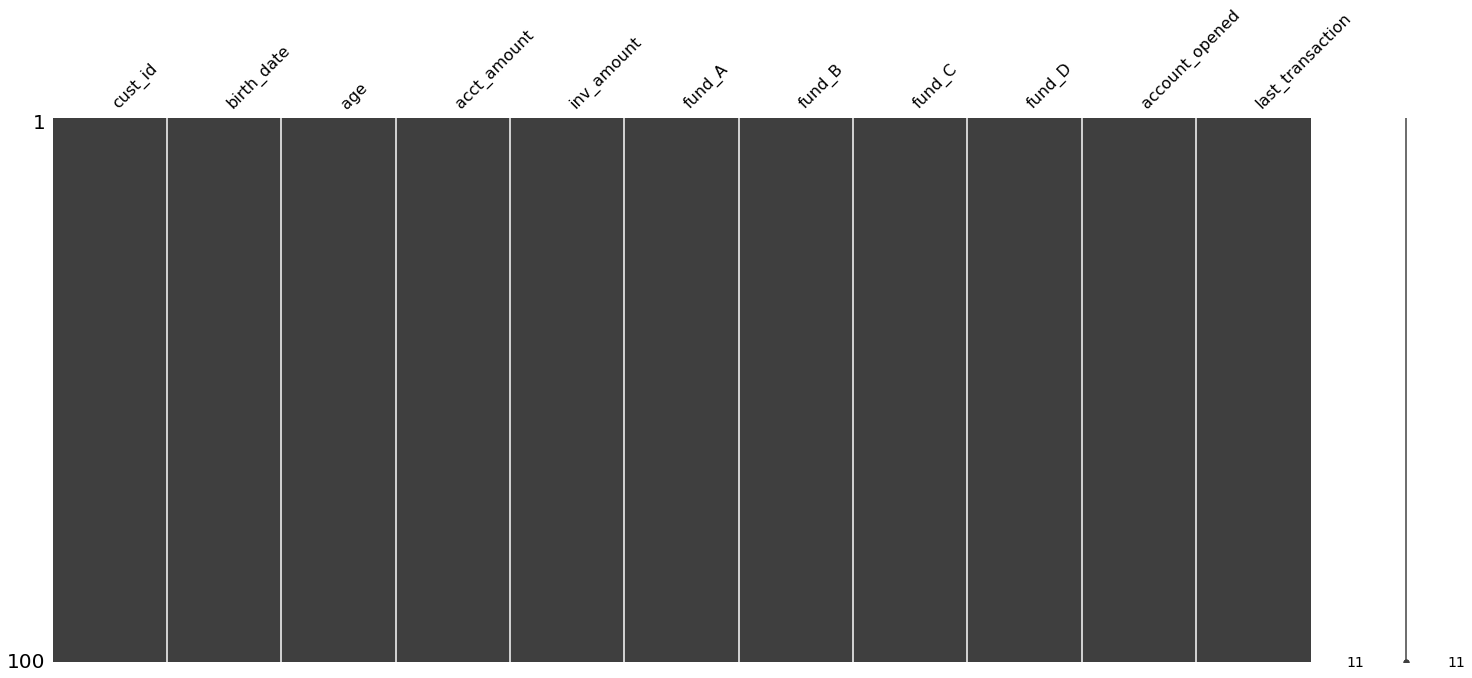

In [28]:
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

In [29]:
# Isolate missing and non missing values of inv_amount
missing_investors = banking[banking.inv_amount.isna()]
investors = banking[banking.inv_amount.notnull()]

In [30]:
missing_investors.describe()

,age,acct_amount,inv_amount,fund_A,fund_B,fund_C,fund_D
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
investors.describe()

,age,acct_amount,inv_amount,fund_A,fund_B,fund_C,fund_D
count,100.000000,1.000000e+02,100.000000,100.000000,100.00000,100.00000,100.00000
mean,43.090000,3.027560e+06,46006.300000,11474.067600,11824.45330,11901.84080,10971.52570
std,9.919978,2.104214e+07,26526.791616,12432.069917,11081.38577,14084.34211,9487.15002
min,27.000000,1.220984e+04,3214.000000,41.000000,312.00000,67.00000,118.00000
25%,34.750000,5.921813e+04,23524.250000,2317.000000,3387.50000,2272.25000,4044.75000
50%,45.000000,8.334416e+04,45785.500000,6489.000000,8089.00000,6811.00000,8480.00000
75%,51.000000,9.509747e+04,66595.750000,15585.000000,17678.25000,15426.75000,15754.00000
max,59.000000,1.737431e+08,96614.000000,58179.000000,51281.00000,75499.00000,51708.00000


The inv_amount is missing only for young customers, since the average age in missing_investors is 22 and the maximum age is 25.

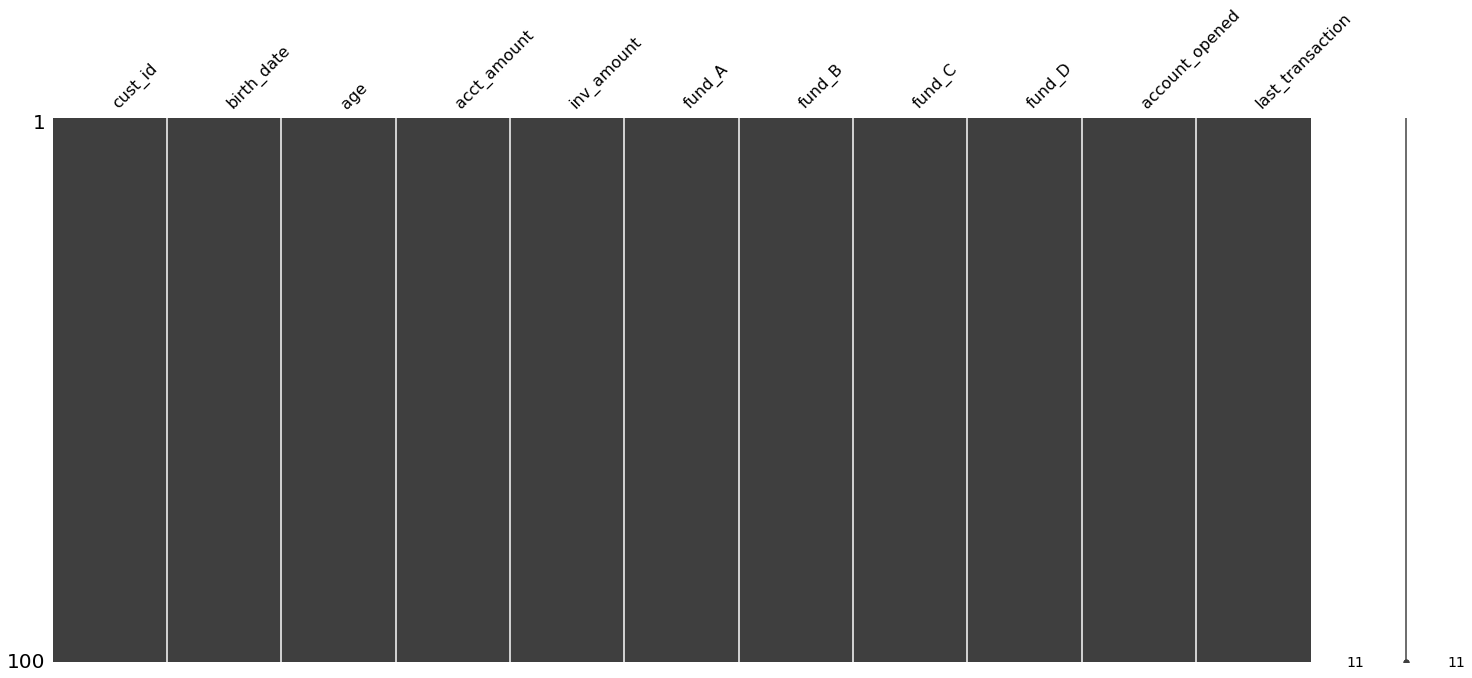

In [32]:
# Sort banking by age and visualize
banking_sorted = banking.sort_values('age')
msno.matrix(banking_sorted)
plt.show()

Notice how all the white spaces for `inv_amount` are on top? Indeed missing values are only due to young bank account holders not investing their money! Better set it to `0` with `.fillna()`.

### Follow the money

We want to produce analysis on how many unique customers the bank has, the average amount held by customers and more. We know that rows with missing `cust_id` don't really help us, and that on average `acct_amount` is usually `5` times the amount of `inv_amount`. We will drop rows of `banking` with missing `cust_ids`, and impute missing values of `acct_amount` with some domain knowledge.

In [33]:
banking = pd.read_csv('../data/banking_id_amount.csv')
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid.inv_amount * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())

cust_id             0
acct_amount         0
inv_amount          0
account_opened      0
last_transaction    0
dtype: int64


# 4. Record linkage
Record linkage is a powerful technique used to merge multiple datasets together, used when values have typos or different spellings. We will link records by calculating the similarity between strings—you’ll then use your new skills to join two restaurant review datasets into one clean master dataset.

## Comparing Strings
minimum edit distance is the minimum number of steps needed to reach from String A to String B, with the operations available being:

* **Insertion** of a new character.
* **Deletion** of an existing character.
* **Substitution** of an existing character.
* **Transposition** of two existing consecutive characters.

We will be working with the `restaurants` DataFrame which has data on various restaurants. Our ultimate goal is to create a restaurant recommendation engine, but we need to first clean your data. This version of `restaurants` has been collected from many sources, where the `cuisine_typ`e column is riddled with typos, and should contain only `italian`, `american` and `asian` cuisine types. There are so many unique categories that remapping them manually isn't scalable, and it's best to use string similarity instead. Before doing so, lets establish the cutoff point for the similarity score using the `fuzzywuzzy`'s `process.extract()` function by finding the similarity score of the most distant typo of each category.

In [36]:
restaurants = pd.read_csv('../data/restaurants.csv')
restaurants.head()

,rest_name,rest_addr,city,phone,cuisine_type
0,arnie morton s of chicago,435 s. la cienega blv .,los angeles,3102461501,america
1,art s delicatessen,12224 ventura blvd.,studio city,8187621221,merican
2,campanile,624 s. la brea ave.,los angeles,2139381447,amurican
3,fenix,8358 sunset blvd. west,hollywood,2138486677,americen
4,grill on the alley,9560 dayton way,los angeles,3102760615,americann


In [37]:
# Store the unique values of cuisine_type in unique_types
unique_types = restaurants.cuisine_type.unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit=len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit=len(unique_types)))

[('asian', 100), ('asiane', 91), ('asiann', 91), ('asiian', 91), ('asiaan', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('italiano', 72), ('italianne', 72), ('italian', 67), ('amurican', 62), ('american', 62), ('italiaan', 62), ('italiian', 62), ('itallian', 62), ('americann', 57), ('americano', 57), ('ameerican', 57), ('aamerican', 57), ('ameriican', 57), ('amerrican', 57), ('ammericann', 54), ('ameerrican', 54), ('ammereican', 54), ('america', 50), ('merican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('americin', 46), ('amerycan', 46), ('itali', 40)]
[('american', 100), ('americann', 94), ('americano', 94), ('ameerican', 94), ('aamerican', 94), ('ameriican', 94), ('amerrican', 94), ('america', 93), ('merican', 93), ('ammericann', 89), ('ameerrican', 89), ('ammereican', 89), ('amurican', 88), ('americen', 88), ('americin', 88), ('amerycan', 88), ('murican', 80), ('asian', 62), ('asiane', 57), ('asiann', 57), ('asiian', 57), ('asiaan', 57), ('italian', 53), (

### Remapping categories II

the distance cutoff point for remapping typos of `'american', 'asian', and 'italian'` cuisine types stored in the `cuisine_type` column should be 80.

We're going to put it all together by finding matches with similarity scores equal to or higher than 80 by using `fuzywuzzy.process's extract()` function, for each correct cuisine type, and replacing these matches with it.

when comparing a string with an array of strings using `process.extract()`, the output is a list of tuples where each of tuple is as such:
```python

(closest match, similarity score, index of match)
```

In [38]:
categories = ['asian', 'american', 'italian']

# For each correct cuisine_type in categories
for cuisine in categories:
    # Find matches in cuisine_type of restaurants
    matches = process.extract(cuisine, restaurants['cuisine_type'], 
                 limit = len(restaurants))
    # For each possible_match with similarity score >= 80
    for possible_match in matches:
        if possible_match[1] >= 80:
            # Find matching cuisine type
            matching_cuisine = restaurants['cuisine_type'] == possible_match[0]
            restaurants.loc[matching_cuisine, 'cuisine_type'] = cuisine

# Print unique values to confirm mapping
restaurants['cuisine_type'].unique()

array(['american', 'asian', 'italian'], dtype=object)